# How to Study Evolution Using Scientific Python 
## by Yoav Ram

This notebook was produced for [PyCon Israel 2016](http://il.pycon.org/2016/) by [Yoav Ram](http://www.yoavram.com).

The most recent version of this notebook, as well as some additional material and info, can be found at <https://github.com/yoavram/PyConIL2016>.

## Versions and setup

The notebook was written using Python 3.5 but should also work with 3.4.

To run the notebook, first [download the repository](https://github.com/yoavram/PyConIL2016/archive/master.zip) or clone it with `git`:

> git clone https://github.com/yoavram/PyConIL2016.git

It is recommended that you download [Anaconda](https://store.continuum.io/cshop/), download this [environment.yml](https://raw.githubusercontent.com/yoavram/PyConIL2016/master/environment.yml), and setup a new environment:

> conda create -n PyConIL2016 python=3.5
> activate PyConIL2016
> conda install --file environment.yml
> python -m ipykernel install --name PyConIL2016

You might need to install additional dependencies manually:

- [LLVM](http://llvm.org/) for Numba
- C compiler for Cython (see [cython-hello-world.ipynb](cython-hello-world.ipynb))

Then start the notebook with:

> jupyter notebook

# Fixation probability

We are interested in the probability that a single copy of allele **1** fixes in a population of $N-1$ **0** alleles, where allele **1** is favored by natural selection such that its relative fitness compared to allele **0** is $1+s$.

## Pure Python

In [ ]:
import random

In [6]:
def simulation(N, s):
    n1 = 1

    while 0 < n1 < N:
        n0 = N - n1
        p1 = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = sum(
            1 
            for _ in range(N) 
            if random.random() < p1
        )              

    return n1 == N

print("Fixate?", simulation(N=1000, s=0.1))

Fixate? True


In [7]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

100 loops, best of 3: 6.42 ms per loop
1 loop, best of 3: 528 ms per loop


## NumPy

In [141]:
import numpy as np
print("NumPy", np.__version__)

NumPy 1.11.0


In [9]:
def simulation(N, s):
    n1 = 1

    while 0 < n1 < N:
        n0 = N - n1
        p1 = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = np.random.binomial(N, p1)        

    return n1 == N

print("Fixate?", simulation(N=1000, s=0.1))

Fixate? False


In [10]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10000 loops, best of 3: 150 µs per loop
1000 loops, best of 3: 313 µs per loop


## Cython

See [cython-hello-world.ipynb](cython-hello-world.ipynb) for setup instructions.

In [140]:
import Cython
print("Cython", Cython.__version__)
%load_ext Cython

Cython 0.24
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [13]:
%%cython
import numpy as np
cimport numpy as np

def simulation(np.uint64_t N, np.float64_t s):
    cdef np.uint64_t n1 = 1
    cdef np.uint64_t n0    
    cdef np.float64_t p
    
    while 0 < n1 < N:
        n0 = N - n1
        p1 = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = np.random.binomial(N, p1)               

    return n1 == N

In [14]:
print("Fixate?", simulation(N=1000, s=0.1))

Fixate? False


In [15]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10000 loops, best of 3: 87.8 µs per loop
1000 loops, best of 3: 177 µs per loop


## Numba

In [17]:
import numba
print("Numba", numba.__version__)

Numba 0.25.0


In [18]:
@numba.jit(locals=dict(s=numba.float64, N=numba.uint64, n0=numba.uint64, n1=numba.uint64, p=numba.float64))
def simulation(N, s):
    n1 = 1

    while N > n1 > 0:
        n0 = N - n1
        p = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = np.random.binomial(N, p)        

    return n1 == N

print("Fixate?", simulation(N=1000, s=0.1))

Fixate? False


In [26]:
%timeit -n 1000 -r 1 simulation(N=1000, s=0.1)
%timeit -n 1000 -r 1 simulation(N=1000000, s=0.01)

1000 loops, best of 1: 50.1 µs per loop
1000 loops, best of 1: 70.3 ms per loop


# Multiple simulations

## Pure Python

In [27]:
def one_simulation(N, s):
    n1 = 1

    while N > n1 > 0:
        p = n1 * (1 + s) / (N + n1 * s)
        n1 = sum(1 for _ in range(N) if random.random() < p)              

    return n1 == N

def simulation(N, s, repetitions=1000):
    return [one_simulation(N, s) for _ in range(repetitions)]

fixations = simulation(N=1000, s=0.1, repetitions=1000)
print("Fixate %", sum(fixations)/len(fixations))

Fixate % 0.19


In [28]:
%timeit simulation(N=1000, s=0.1)

1 loop, best of 3: 8.11 s per loop


## NumPy

In [29]:
def simulation(N, s, repetitions=1000):
    n1 = np.ones(repetitions, dtype=np.uint64)
    update = (n1 > 0) & (n1 < N)
    
    while update.any():
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        update = (n1 > 0) & (n1 < N)

    return n1 == N

print("Fixate %", simulation(N=1000, s=0.1).mean())

Fixate % 0.187


In [30]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10 loops, best of 3: 25.2 ms per loop
1 loop, best of 3: 218 ms per loop


## Cython

In [31]:
%%cython
cimport cython
import numpy as np
cimport numpy as np

def simulation(np.uint64_t N, np.float64_t s, np.uint32_t repetitions=1000):
    cdef np.ndarray[np.uint64_t] n1 = np.ones(repetitions, dtype=np.uint64)
    cdef np.ndarray[np.uint8_t, cast=True] update = (n1 > 0) & (n1 < N)
    cdef np.ndarray[np.float64_t] p
    
    while update.any():
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        update = (n1 > 0) & (n1 < N)

    return n1 == N

In [32]:
print("Fixate %", simulation(N=1000, s=0.1).mean())

Fixate % 0.182


In [33]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10 loops, best of 3: 37.1 ms per loop
1 loop, best of 3: 353 ms per loop


## Fixation probability as function of population size

Kimura's equation:

$$
\frac{1 - e^{-2s}}{1 - e^{-2Ns}}
$$

For large $N$, the denominator is roughly 1, and if $s$ is small than we can approximate this by $2s$. 

In [36]:
def kimura(N, s):
    return np.expm1(-2 * s) / np.expm1(-2 * N * s)

In [37]:
Nrange_kimura = np.logspace(1, 6, 50000, dtype=np.int64)
s = 0.1

In [38]:
%timeit [kimura(N=N, s=s) for N in Nrange_kimura]
%timeit -n 1000 kimura(N=Nrange_kimura, s=s)

1 loop, best of 3: 752 ms per loop
1000 loops, best of 3: 3.91 ms per loop


## [Numexpr](https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide)

In [39]:
import numexpr as ne
print("Numexpr", ne.__version__)
print(ne.get_vml_version())

Numexpr 2.5.2
Intel(R) Math Kernel Library Version 11.3.1 Product Build 20151021 for Intel(R) 64 architecture applications


In [40]:
def kimura(N, s):
    return ne.evaluate("expm1(-2 * s) / expm1(-2 * N * s)")

In [41]:
%timeit -n 1000 kimura(N=Nrange_kimura, s=s)

1000 loops, best of 3: 803 µs per loop


## Plot fixation probability

In [52]:
repetitions = 1000
s = 0.01
Nrange = np.logspace(1, 6, 20, dtype=np.uint64)

In [53]:
fix_prob_sim = np.array([
    simulation(N=N, s=s, repetitions=repetitions)
    for N in Nrange
])

fix_prob_sim_mean = fix_prob_sim.mean(axis=1)
fix_prob_sim_sem = fix_prob_sim.std(axis=1, ddof=1) / np.sqrt(repetitions)

In [54]:
Nrange_kimura = np.logspace(1, 6, 500)
fix_prob_kimura = kimura(N=Nrange_kimura, s=s)

In [139]:
%matplotlib inline
import matplotlib as mpl
print("Matplotlib", mpl.__version__)
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    print("Seaborn", sns.__version__)
    sns.set_style('ticks')
    sns.set_context('talk', font_scale=1.5)
    sns.set_palette('colorblind')
except ImportError:
    print("Install seaborn for plot aesthetics")
    plt.style.use('fivethirtyeight')

Matplotlib 1.5.1
Seaborn 0.7.0


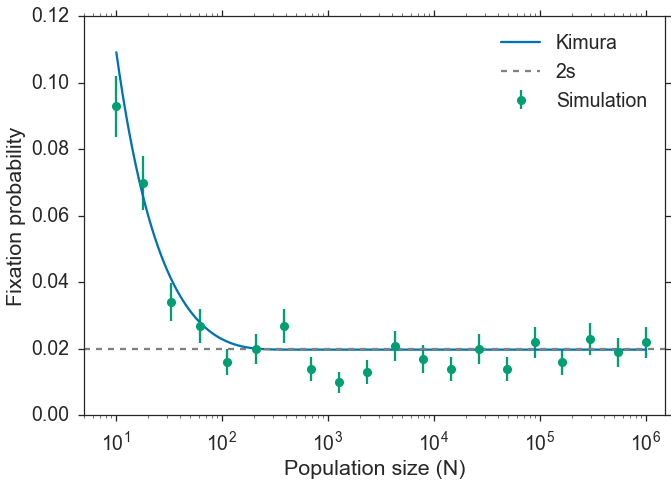

In [55]:
fig, ax = plt.subplots(1, 1)

ax.plot(Nrange_kimura, fix_prob_kimura, ls='-', label='Kimura')
ax.axhline(2*s, color='gray', ls='--', label='2s')
ax.errorbar(x=Nrange, y=fix_prob_sim_mean, yerr=fix_prob_sim_sem, 
            fmt='o', capsize=5, label='Simulation')


ax.set(
    xlabel='Population size (N)',
    ylabel='Fixation probability',
    xscale='log', 
    xlim=(0.5 * Nrange.min(), 1.5 * Nrange.max()),
)
ax.legend();

# Fixation time

Now we will focus on the time it takes for the fixation of one of the alleles to occur.

In [113]:
def simulation(N, s, repetitions=1000):
    N = int(N) # very important! if this is a float than the while loop will be ~infinite
    n1 = np.ones(repetitions, dtype=np.uint64)
    T = np.empty_like(n1)
    update = (n1 > 0) & (n1 < N)
    t = 0
    
    while update.any():
        t += 1
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        T[update] = t
        update = (n1 > 0) & (n1 < N)

    return n1 == N, T

print("Fixate %", simulation(N=1000, s=0.1)[0].mean())

Fixate % 0.165


In [57]:
%timeit simulation(N=10, s=0.01, repetitions=1000)
%timeit simulation(N=1000000, s=0.01, repetitions=1000)

100 loops, best of 3: 11.8 ms per loop
1 loop, best of 3: 418 ms per loop


In [58]:
fixations, times = simulation(N=10000, s=0.1, repetitions=1000)
fixation_prob = fixations.mean()
fixation_time = times[fixations].mean()
print("% Fixation: {:.2g}".format(fixation_prob))
print("Avg. time: {:.0f}".format(fixation_time))

% Fixation: 0.18
Avg. time: 168


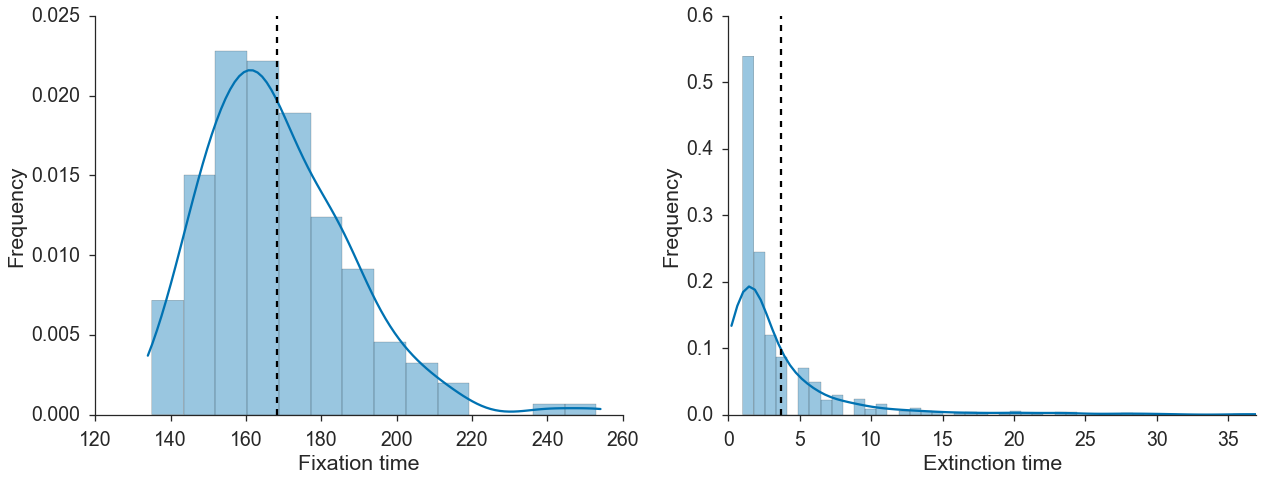

In [59]:
w, h = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(1, 2, figsize=(2 * w, h))

sns.distplot(times[fixations], ax=ax[0])
ax[0].axvline(times[fixations].mean(), color='k', ls='--')
ax[0].set(xlabel='Fixation time', ylabel='Frequency')

sns.distplot(times[~fixations], ax=ax[1])
ax[1].axvline(times[~fixations].mean(), color='k', ls='--')
ax[1].set(xlabel='Extinction time', ylabel='Frequency', 
          xlim=(0, times[~fixations].mean()*10))
sns.despine()

In [60]:
%%cython
cimport cython
import numpy as np
cimport numpy as np

def simulation(np.uint64_t N, np.float64_t s, np.uint32_t repetitions=1000):
    cdef np.ndarray[np.uint64_t] n1 = np.ones(repetitions, dtype=np.uint64)
    cdef np.ndarray[np.uint64_t] T = np.empty_like(n1)
    cdef np.ndarray[np.uint8_t, cast=True] update = (n1 > 0) & (n1 < N)
    cdef np.ndarray[np.float64_t] p
    cdef np.uint64_t t = 0
    
    while update.any():
        t += 1
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        T[update] = t
        update = (n1 > 0) & (n1 < N)

    return n1 == N, T

In [61]:
%timeit simulation(N=10, s=0.01, repetitions=1000)
%timeit simulation(N=1000000, s=0.01, repetitions=1000)

100 loops, best of 3: 12.6 ms per loop
1 loop, best of 3: 443 ms per loop


## Fixation time as function of population size

In [117]:
repetitions = 1000
s = 0.1
Nrange = np.logspace(1, 6, 10, dtype=np.uint64)

def fix_time_simulation(N):
    fixations, times = simulation(N=N, s=s, repetitions=repetitions)
    fixation_time_mean = times[fixations].mean()
    fixation_time_std =  times[fixations].std(ddof=1) / np.sqrt(repetitions)
    return fixation_time_mean, fixation_time_std

fix_time_sim = np.array([
    fix_time_simulation(N=N)
    for N in Nrange
])

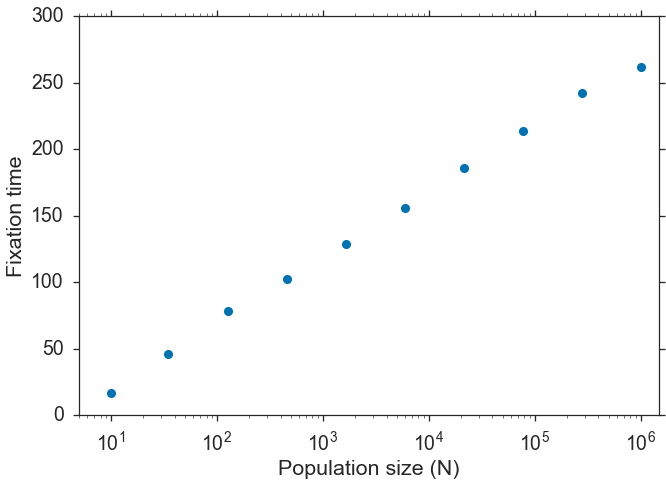

In [115]:
def fixation_time_plot(N, mean, sem):
    fig, ax = plt.subplots(1, 1)

    ax.errorbar(x=N, y=mean, yerr=sem, 
                fmt='o', capsize=5, label='Simulation')

    ax.set(
        xlabel='Population size (N)',
        ylabel='Fixation time',
        xscale='log', 
        xlim=(0.5 * Nrange.min(), 1.5 * Nrange.max()),
    )
    return fig, ax

fixation_time_plot(Nrange, fix_time_sim[:,0], fix_time_sim[:,1]);

## Fixation time approximations

### Deterministic approximation

The first approximation is attributed to [Haldane 1924](http://link.springer.com/article/10.1007%2FBF02459574) (via [Hartfiled & Otto 2011](http://www.ncbi.nlm.nih.gov/pubmed/21884046)).

The frequency of the mutant can be approximated by: 

$$
f(t) = \frac{f(0)}{f(0) + (1-f(0))(1-s)^t}
$$
or assuming $f(0)=1/N$ and $N-1 \approx N$:
$$
f(t) = \frac{1}{1 + N (1-s)^t}
$$

Inversing this equation and looking for time $T_{fix}$ in which $f(T_{fix})=\frac{N-1}{N}$ we get:
$$
T_{fix} = -2 \frac{\log{N}}{\log{(1-s)}}
$$

In [108]:
def T_haldane(N, s):
    return -2 * np.log(N) / np.log1p(-s)
%timeit T_haldane(np.logspace(2, 9, 100000), 0.01)
def T_haldane(N, s):
    return ne.evaluate("-2 * log(N) / log1p(-s)")
%timeit T_haldane(np.logspace(2, 9, 100000), 0.01)

100 loops, best of 3: 13.9 ms per loop
100 loops, best of 3: 11.3 ms per loop


### Stochastic approximation

A more complex approximation is based on a *diffusion equation* and is taken from eq. (17) in [Kimura and Ohta 1969](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=1212239) (the reference assumes a population size of $2N$ gametes and selection advantage of $s/2$ rather then $N$ and $s$, therefore I'm changing $s=2s$ and $N=N/2$).

$$
I_1(x) = \frac{1 - e^{-2Nsx} - e^{-2Ns(1-x)} + e^{-2Ns}}{x(1-x)} \\
I_2(x) = \frac{(e^{2Nsx} - 1) (1 - e^{-2Ns(1-x)})}{x(1-x)} \\
J_1 = \frac{1}{s(1-e^{-2Ns})} \int_{x}^{1}{I_1(y) dy} \\
J_2 = \frac{1}{s(1-e^{-2Ns})} \int_{0}^{x}{I_2(y) dt} \\
u = \frac{1 - e^{-2Nsx}}{1 - e^{-2Ns}} \\
T_{fix} = J1 + \frac{1-u}{u} J_2
$$

Here we need to integrate some functions, we'll do this using `scipy.integrate.quad`. 

`functools.partial` reduces the number of arguments a function expects, effectively freezing some of them - mathematically, it creates a projection.

In [97]:
from scipy.integrate import quad 
from functools import partial

def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]

In [106]:
def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))

@np.vectorize
def T_kimura(N, s):
    x = 1.0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

assert 254 < T_kimura(1e6, 0.1) < 255

In [103]:
Nrange_kimura = np.logspace(1, 6, 1000)
%timeit x = np.array([T_kimura(N=N, s=s) for N in Nrange_kimura])
%timeit y = T_kimura(N=Nrange_kimura, s=s)

1 loop, best of 3: 9.02 s per loop
1 loop, best of 3: 4.34 s per loop


In [119]:
s = 0.1
Nrange_kimura = np.logspace(1, 6, 100)
fix_time_kimura = T_kimura(N=Nrange_kimura, s=s)
fix_time_haldane = T_haldane(N=Nrange_kimura, s=s)

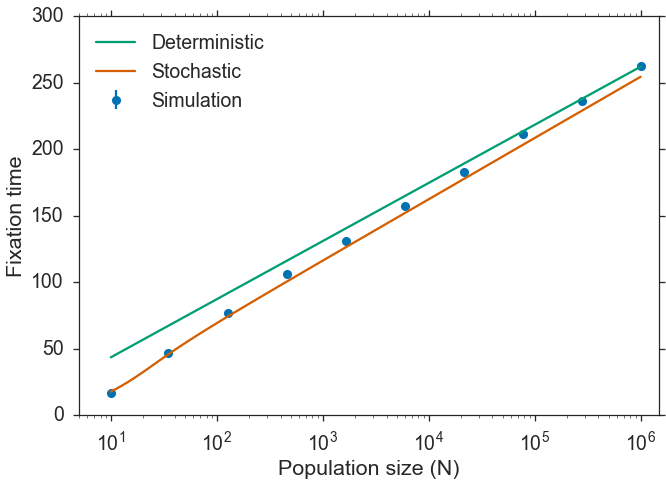

In [121]:
fig, ax = fixation_time_plot(Nrange, fix_time_sim[:,0], fix_time_sim[:,1]);
ax.plot(Nrange_kimura, fix_time_haldane, ls='-', label='Deterministic')
ax.plot(Nrange_kimura, fix_time_kimura, ls='-', label='Stochastic')
ax.legend(loc='upper left');

## Parallelization with [IPyParallel](http://ipyparallel.readthedocs.org/)

In [122]:
def simulation(N, s, repetitions=1000):
    import numpy as np # needed for parallel runs
    N = int(N)
    
    n1 = np.ones(repetitions, dtype=np.uint64)
    T = np.empty_like(n1)
    update = (n1 > 0) & (n1 < N)
    t = 0
    
    while update.any():
        t += 1
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        T[update] = t
        update = (n1 > 0) & (n1 < N)

    return n1 == N, T

print("Fixate %", simulation(N=1000, s=0.1)[0].mean())

Fixate % 0.173


In [123]:
%timeit simulation(N=1000000, s=0.01, repetitions=1000)

1 loop, best of 3: 364 ms per loop


In [124]:
def fix_time_aggregate(sim_results):
    fixations, times = sim_results
    fixation_time_mean = times[fixations].mean()
    fixation_time_sem =  times[fixations].std(ddof=1) / np.sqrt(repetitions)
    return fixation_time_mean, fixation_time_sem

fixation_time_mean, fixation_time_sem = fix_time_aggregate(simulation(N=1000000, s=0.01, repetitions=1000))
print("Mean time: {:.2f} +- {:.5f} (sem)".format(fixation_time_mean, fixation_time_sem))

Mean time: 2035.00 +- 5.94276 (sem)


We can't use `%timeit` with parallelized code, so this is a simple context manager to measure time:

In [125]:
import contextlib
import time

@contextlib.contextmanager
def tictoc():
    tic = time.time()
    yield tic
    toc = time.time()
    print("Elapsed: {:.4f} seconds".format(toc - tic))

In [126]:
repetitions = 1000
s = 0.01
Nrange = np.logspace(1, 6, 50)

with tictoc():
    fix_time_sim = [
        simulation(N=N, s=s, repetitions=repetitions)
        for N in Nrange
    ]

Elapsed: 9.7886 seconds


Now let's try to parallelize with IPyParallel. 

In [127]:
import ipyparallel
print("IPython Parallel", ipyparallel.__version__)
from ipyparallel import Client

IPython Parallel 5.0.1


Open a terminal and start the IPython cluster with the following command:
```
$ ipcluster start --n=4
```
Now you can connect to the cluster:

In [129]:
rc = Client()
print("Engines IDs", rc.ids)
dview = rc[:] # use all engines

Engines IDs [0, 1, 2]


In [130]:
with tictoc():
    fix_time_sim = dview.map_sync(
        simulation, 
        Nrange,
        [s]*len(Nrange),
        [repetitions]*len(Nrange)
    )

Elapsed: 5.9733 seconds


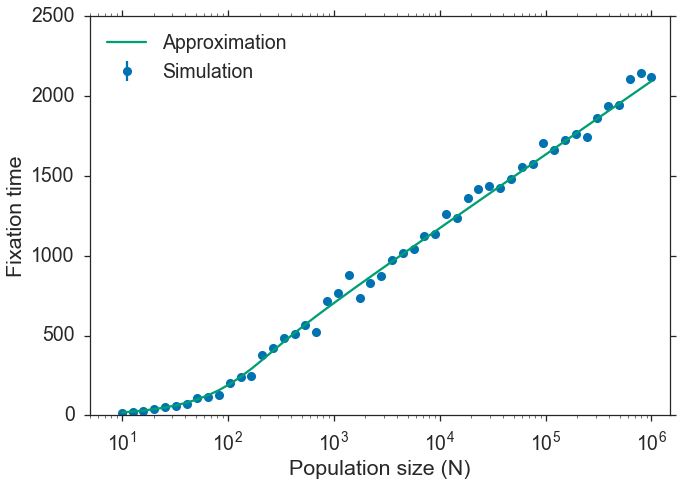

In [131]:
_ = np.array([fix_time_aggregate(res) for res in fix_time_sim])
fixation_time_mean = _[:,0]
fixation_time_sem  = _[:,1]

fig, ax = fixation_time_plot(Nrange, fixation_time_mean, fixation_time_sem)
ax.plot(Nrange, T_kimura(Nrange, s), label='Approximation')
ax.legend(loc=2);

# IPyWidgets

IPyWidgets are great for interacting with plots.

Here is a static plot of Kimura's approximation to the fixation time:

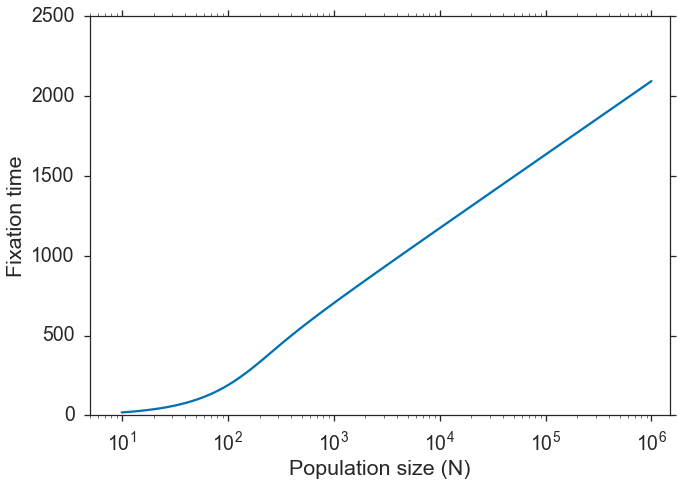

In [145]:
def approximation_plot(log10Nmax=6, log10s=-2):
    fig, ax = plt.subplots(1, 1)
    
    Nrange = np.logspace(1, log10Nmax, 1000)
    s = 10**log10s
    ax.plot(Nrange_kimura, T_kimura(Nrange_kimura, s))

    ax.set(
        xlabel='Population size (N)',
        ylabel='Fixation time',
        xscale='log', 
        xlim=(0.5 * Nrange_kimura.min(), 1.5 * Nrange_kimura.max()),
    )
            
approximation_plot();

In [146]:
import ipywidgets
print("IPyWidgets", ipywidgets.__version__)

IPyWidgets 4.1.1


Running the following command will create an interactive plot with sliders for the maximum of $\log_{10}{N}$ and $\log_{10}{s}$.

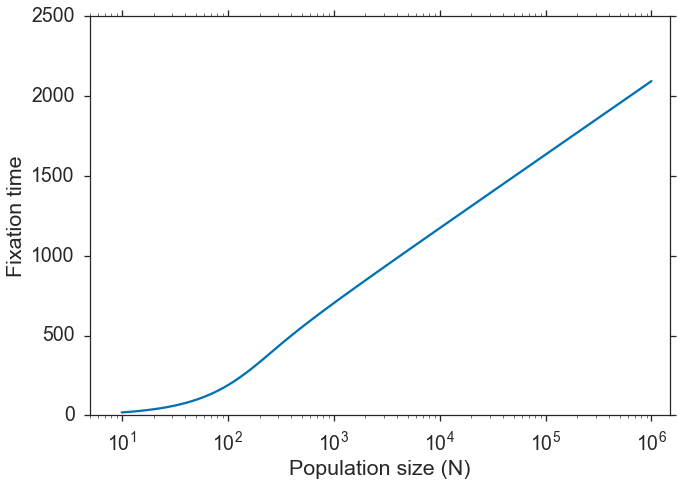

In [147]:
ipywidgets.interact(approximation_plot, log10Nmax=(1.0, 12.0), log10s=(-6.0, -1.0));

# Multi-type

The above simulations are hard to extend for a multi-type model in which there are more than two types, because we used scalar arithmetics and the binomial distribution.

The following is the extension that uses matrix multiplication and the multinomial distribution.

There are now **L** types; the fitness of type **i** is $(1+s)^i$; type **i** can mutate to types **i-1** and **i+1** with probability $m$.

Note the use of the matrix multiplication operator, `@`, which is new in Python 3.5 and NumPy 1.10. If you are using an earlier version, replace `M @ S` and `E @ p` with `M.dot(S)` and `E.dot(p)`.

In [ ]:
def simulation(N, s, m, L, repetitions=1000):
    assert N > 0
    N = np.uint64(N)
    
    w = (1 + s) ** np.arange(L)
    S = np.diag(w)
    
    M = np.diag(np.repeat(1 - 2 * m, L))
    M += np.diag(np.repeat(m, L - 1), 1)
    M += np.diag(np.repeat(m, L - 1), -1)
    
    E = M @ S

    # rows are genotypes, cols are repretitions
    n = np.zeros((L, repetitions))
    n[0,:] = N    
    # which columns to update
    update = np.array([True] * repetitions)
    # follow time
    T = np.zeros(repetitions)
    t = 0
    # follow population mean fitness
    W = []
    
    while update.any():
        t += 1
        T[update] = t        
        p = n/N  # counts to frequencies
        W.append(w.reshape(1, L) @ p)  # mean fitness
        p = E @ p  # natural selection + mutation        
        p /= p.sum(axis=0)  # mean fitness
        for j in update.nonzero()[0]:
            # random genetic drift
            n[:,j] = np.random.multinomial(N, p[:,j])
        update = (n[-1,:] < N)  # fixation of fittest genotype
        
    return T, W

In [168]:
N=10000
s=0.1
m=1e-4
L=5

times, fitness = simulation(N, s, m, L, repetitions=1000)
print("Adaptation time: {:.2f}".format(times.mean()))

Adaptation time: 441.34


In [240]:
import pandas as pd
print("Pandas", pd.__version__)

Pandas 0.18.0


Put fitness data in a pandas data frame:

In [196]:
fitness = np.array(fitness).squeeze()
df = pd.DataFrame(data=fitness)
df['Time'] = df.index
df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Time
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0
1,1.00002,1.00001,1.00001,1.00000,1.00003,1.00000,1.00002,1.00002,1.00002,1.00000,...,1.00002,1.00002,1.00001,1.00000,1.00001,1.00001,1.00002,1.00001,1.00002,1
2,1.00003,1.00002,1.00002,1.00000,1.00001,1.00001,1.00003,1.00005,1.00002,1.00000,...,1.00001,1.00001,1.00004,1.00001,1.00001,1.00001,1.00004,1.00004,1.00002,2
3,1.00003,1.00007,1.00003,1.00004,1.00001,1.00002,1.00006,1.00004,1.00001,1.00001,...,1.00003,1.00001,1.00007,1.00001,1.00002,1.00002,1.00003,1.00004,1.00005,3
4,1.00004,1.00012,1.00004,1.00002,1.00000,1.00001,1.00007,1.00008,1.00001,1.00002,...,1.00001,1.00001,1.00010,1.00001,1.00002,1.00002,1.00007,1.00006,1.00005,4


Melt the data frame so that each fitness value has its own row:

In [197]:
df = pd.melt(df, id_vars='Time', var_name='Replicate', value_name='Fitness')
df.head()

,Time,Replicate,Fitness
0,0,0,1.00000
1,1,0,1.00002
2,2,0,1.00003
3,3,0,1.00003
4,4,0,1.00004


Now group by `Time` and calculate the average fitness across all replicates. `reset_index` recreates the `Time` column.

In [206]:
mean_df = df.groupby('Time')['Fitness'].mean().reset_index()
mean_df.head()

,Time,Fitness
0,0,1.000000
1,1,1.000010
2,2,1.000022
3,3,1.000035
4,4,1.000047


Now draw a random sample of 5% of simulations:

In [255]:
grp = df.groupby('Replicate')
filtered = grp.filter(lambda x: random.random() < 0.05)

Pivot the table - this is the reverse of `melt`:

In [256]:
pivoted = filtered.pivot('Time', 'Replicate', 'Fitness')
pivoted.head()

Replicate,63,65,86,180,196,202,244,277,324,358,...,840,861,867,886,941,944,964,967,969,974
Time,,,,,,,,,,,,,,,,,,,,,
0,1.00000,1.00000,1.00000,1.0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
1,1.00000,1.00001,1.00000,1.0,1.00000,1.00001,1.00001,1.00001,1.00002,1.00001,...,1.00001,1.00002,1.00000,1.00002,1.00000,1.00002,1.00002,1.00002,1.00002,1.00003
2,1.00001,1.00004,1.00000,1.0,1.00002,1.00002,1.00005,1.00004,1.00002,1.00004,...,1.00001,1.00001,1.00001,1.00005,1.00003,1.00004,1.00004,1.00002,1.00004,1.00005
3,1.00002,1.00009,1.00002,1.0,1.00004,1.00004,1.00006,1.00005,1.00004,1.00005,...,1.00002,1.00002,1.00001,1.00008,1.00005,1.00004,1.00004,1.00005,1.00007,1.00005
4,1.00003,1.00014,1.00002,1.0,1.00003,1.00007,1.00007,1.00008,1.00005,1.00005,...,1.00005,1.00005,1.00001,1.00012,1.00006,1.00004,1.00009,1.00003,1.00007,1.00008


We are now ready to plot. 

The left plot is similar to the *Fixation time* plots from above.

The right plot is new - we plot 5% of the simulations using colored solid lines and the average line using a thick black dashed line. The gray line marks the expected theoretical final population mean fitness.

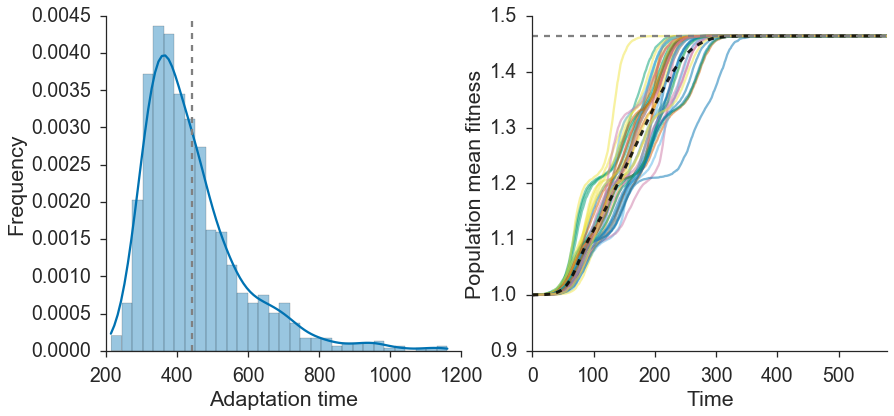

In [257]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.distplot(times, ax=ax[0])
ax[0].axvline(times.mean(), color='gray', ls='--')
ax[0].set(xlabel='Adaptation time', ylabel='Frequency')

pivoted.plot(ax=ax[1], alpha=0.5)
mean_df.plot('Time', 'Fitness', color='k', alpha=0.85, ls='--', lw=3, ax=ax[1])
ax[1].axhline((1 + s)**(L - 1) * (1 - 2 * m), color='gray', ls='--')
ax[1].legend().set_visible(False)
ax[1].set(ylabel='Population mean fitness', xlim=(0, df.Time.max()/2))


sns.despine()

# Colophon

This notebook was produced for [PyCon Israel 2016](http://il.pycon.org/2016/) by [Yoav Ram](http://www.yoavram.com).

The most recent version of this notebook, as well as some additional material and info, can be found at <https://github.com/yoavram/PyConIL2016>.

The notebook is under a CC-BY-SA 3.0 license.